## <u>SCA6.0 - The DHFR (dihydrofolate reductase) family<u/>

**Summary** This script describes the basic flow of the analytical steps in SCA6.0, using the DHFR family as an example. Here we compare results of the analysis for two different alignments: a PFAM alignment (PFAM PF00186) and an independent manually curated alignment constructed using a custom database of orthologous sequences (DHFR_PEPM3.an). Despite differences in the construction, sequence distribution and size of the two alignments, the sector definition is remarkably consistent: in both cases we arrive at a single sector assembled from six independent components. <br\>

For this tutorial, the core calculation scripts should be run from the command line as follows:

    >> ./annotate_MSA.py Inputs/PF00186_full.txt -o Outputs/PF00186_full.an -a 'pfam'
    >> ./scaProcessMSA.py Inputs/PF00186_full.an -s 1RX2 -c A -f 'Escherichia coli' -t -n
    >> ./scaCore.py Outputs/PF00186_full.db 
    >> ./scaSectorID.py Outputs/PF00186_full.db 
    >> ./annotate_MSA.py Inputs/DHFR_PEPM3.fasta -o Outputs/DHFR_PEPM3.an -a 'ncbi' -g Inputs/DHFR_PEPM3.gis
    >> ./scaProcessMSA.py Inputs/DHFR_PEPM3.an -s 1RX2 -c A -t -n
    >> ./scaCore.py Outputs/DHFR_PEPM3.db 
    >> ./scaSectorID.py Outputs/DHFR_PEPM3.db 

Note that we supply annotated alignments for all tutorial scripts *(the annotate_pfMSA step is slow, and should only be run once)*.

**O.Rivoire, K.Reynolds and R.Ranganathan**
9/2014

In [1]:
%matplotlib inline
from __future__ import division

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import colorsys
import matplotlib.image as mpimg
from IPython.display import display
from IPython.display import Image
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile 
import scaTools as sca
import mpld3
import cPickle as pickle
from optparse import OptionParser

if not os.path.exists('Outputs/'): os.makedirs('Outputs/')  

Read in the results of the above three scripts (scaProcessMSA, scaCore and scaSectorID), stored as dictionaries in the databases PF00186_full.db and DHFR_PEPM3.db.  To see what variables are stored in each dictionary, use:

    >> print dict.keys()
    

In [2]:
Dseq = list(); Dsca = list(); Dsect = list()
db = pickle.load(open('Outputs/PF00186_full.db','rb'))
Dseq.append(db['sequence'])
Dsca.append(db['sca'])
Dsect.append(db['sector'])
db2 = pickle.load(open('Outputs/DHFR_PEPM3.db', 'rb'))
Dseq.append(db2['sequence'])
Dsca.append(db2['sca'])
Dsect.append(db2['sector'])
N_alg = 2
AlgName = ['PFAM', 'Manual']

### I. Statistical Structure of the Multiple Sequence Alignment (MSA)


We start with a rough comparison of the sequence composition of the two alignments. Plot a histogram of all pairwise sequence identities *(left panel)* and a global view of the sequence similarity matrix (defined by $S\equiv \frac{1}{L}XX^\top$) *(right panel)*.  The PFAM alignment is show in the *top row* and the manual alignment is shown in the *bottom row*. The manual alignment is smaller (644 seqs vs 2000 for PFAM), but both alignments are well-described by a nearly homogeneous distribution of sequence identities with a mean value of about 35%.

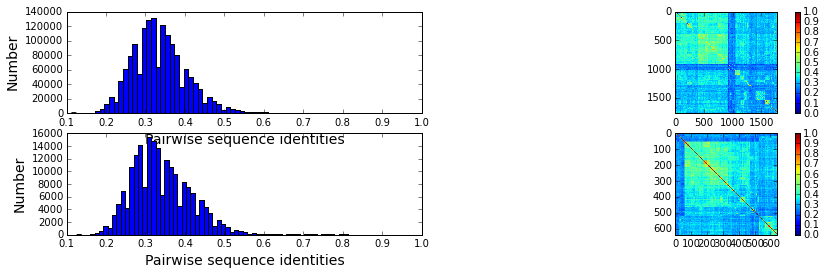

In [3]:
ix = 1
plt.rcParams['figure.figsize'] = 9, 15
for k in range(N_alg):
    # List all elements above the diagonal (i<j):
    listS = [Dsca[k]['simMat'][i,j] for i in range(Dsca[k]['simMat'].shape[0]) \
             for j in range(i+1, Dsca[k]['simMat'].shape[1])]
    #Cluster the sequence similarity matrix
    Z = sch.linkage(Dsca[k]['simMat'],method = 'complete', metric = 'cityblock')
    R = sch.dendrogram(Z,no_plot = True)
    ind = map(int, R['ivl'])
    #Plotting
    plt.rcParams['figure.figsize'] = 14, 4 
    plt.subplot(2,2,ix)
    ix += 1
    plt.hist(listS, Dseq[k]['Npos']/2)
    plt.xlabel('Pairwise sequence identities', fontsize=14)
    plt.ylabel('Number', fontsize=14)
    plt.subplot(2,2,ix)
    ix += 1
    plt.imshow(Dsca[k]['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();   

To examine: (1) sampling differences between the alignments and (2) the relationship between divergence in *sequence similarity* and *phylogeny* for both alignments, we plot the top independent components of the sequence correlation matrix (after sequence weighting), colored by phylogenetic group. We start by constructing a dictionary of phylogenetic annotations and checking the representation of sequences in the top taxonomic levels.  The annotations are parsed from the sequence headers:

In [4]:
for k in range(N_alg):
    print "Alignment: " + AlgName[k]
    #construct a dictionary of phylogenetic groups
    annot = dict()
    for i, h in enumerate(Dseq[k]['hd']):
        hs = h.split('|')
        if (len(hs) == 4):
            annot[hs[0]] = sca.Annot(hs[1], hs[2], hs[3].replace('.',''))
        elif (len(hs) == 3):
            annot[hs[0]] = sca.Annot(hs[0],hs[1], hs[2].replace('.',''))
            
    # Most frequent taxonomic groups:
    atleast = 10
    for level in range(4):
        descr_list = [a.taxo.split(',')[level] for a in annot.values() \
                      if len(a.taxo.split(',')) > level]
        descr_dict = {k:descr_list.count(k) for k in descr_list \
                      if descr_list.count(k)>=atleast}
        print '\n Level %i:' % level
        print descr_dict    

Alignment: PFAM

 Level 0:
{'Eukaryota': 212, 'Archaea': 21, 'Viruses': 38, 'Bacteria': 1494}

 Level 1:
{'environmental samples': 26, 'Tenericutes': 30, 'Alveolata': 11, 'Chlamydiae': 16, 'dsDNA viruses': 37, 'Viridiplantae': 34, 'Firmicutes': 444, 'Bacteroidetes': 160, 'Fungi': 62, 'Actinobacteria': 173, 'Metazoa': 82, 'Proteobacteria': 602, 'Euryarchaeota': 20}

 Level 2:
{'Mollicutes': 30, 'Sphingobacteriia': 13, 'Dikarya': 61, 'Negativicutes': 21, 'Deltaproteobacteria': 18, 'Betaproteobacteria': 119, 'Bacteroidia': 73, 'Coriobacteridae': 11, 'Flavobacteriia': 56, 'Chlamydiales': 16, 'Cytophagia': 12, 'Erysipelotrichi': 16, 'Bacillales': 94, 'Streptophyta': 26, ' no RNA stage': 37, 'Lactobacillales': 173, 'Chordata': 36, 'Clostridia': 140, 'Arthropoda': 31, 'Gammaproteobacteria': 312, 'Halobacteria': 18, 'Nematoda': 10, 'Actinobacteridae': 161, 'Alphaproteobacteria': 151}

 Level 3:
{'Erysipelotrichales': 16, 'Streptococcaceae': 66, 'Bacillaceae': 45, 'Rickettsiales': 12, 'Ascomyco

Based on this, we select taxonomic groups and colors for representation.  Here, we just start by choosing the broadly well-represented groups. To see a complete color-coding legend, use: 
    
    >>> sca.figColors()

In [5]:
phylo = list();
fam_names = ['Eukaryota', 'Bacteroidetes', 'Firmicutes', \
             'Actinobacteria', 'Proteobacteria']
col = (0, 0.18, 0.38, 0.6, 0.8) 
#Eukaryota = red, Bacteriodetes = yellow, Firmicutes = green, 
#Actinobacteria = blue, Proteobacteria = purple
for a in range(N_alg):
    phylo_alg = list()
    for i,k in enumerate(fam_names):
        sf = sca.Unit()
        sf.name = fam_names[i].lower()
        sf.col = col[i]
        sf.items = [j for j,q in enumerate(Dseq[a]['hd'])  \
                    if sf.name in q.lower()]
        phylo_alg.append(sf)
    phylo.append(phylo_alg)    

Plot the top six independent components of the sequence correlation matrix (with sequence weights); color-coded by phylogenetic annotation. We compare the phylogenetic sampling for the PFAM alignment *(top row)* and manual alignment*(bottom row)*. The data show some very clear seqeunce distinctions based on phylogeny, and the two alignments seem to differ somewhat in the sequence divergence captured. In particular, the eukaryotic sequences *(in red)* seem to form a more distinct group in  the manual alignment than in the PFAM alignment. For the PFAM alignment, the bacteriodetes *(yellow)* diverge along $U_1$, the actinobacteria *(blue)* along $U_3$, the firmicutes *(green)* along $U_4$ and $U_5$, and a subset of proteobacteria *(purple)* along $U_6$. For the manual alignment, the eukaryotes *(red)* diverge along $U_2$ and $U_6$, the actinobacteria *(blue)* along $U_4$, the firmicutes *(green)* along $U_3$, and a subset of proteobacteria *(purple)* along $U_5$


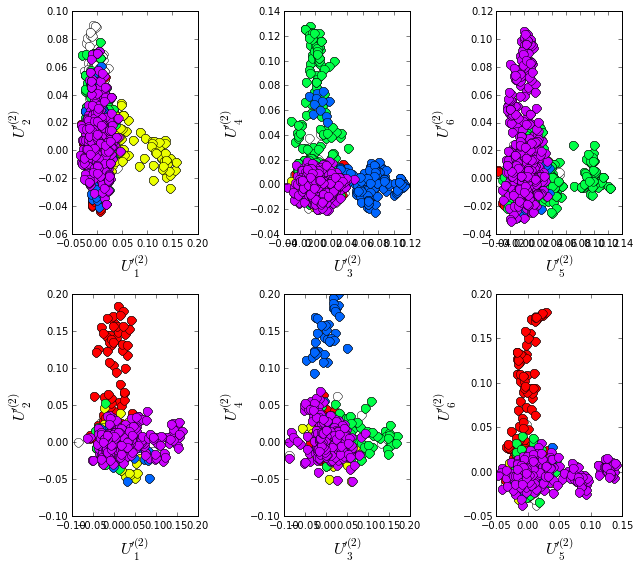

In [6]:
plt.rcParams['figure.figsize'] = 9, 8
ix = 1;
for a in range(N_alg):
    U = Dsca[a]['Uica'][1]
    pairs = [[2*i,2*i+1] for i in range(3)]
    for k,[k1,k2] in enumerate(pairs):
        plt.subplot(2,3,ix)
        ix += 1
        sca.figUnits(U[:,k1], U[:,k2], phylo[a])
        #sca.figUnits(U[:,k1], U[:,k2], subfam)
        plt.xlabel(r"${U'}^{(2)}_{%i}$"%(k1+1), fontsize=16)
        plt.ylabel(r"${U'}^{(2)}_{%i}$"%(k2+1), fontsize=16)
    plt.tight_layout()

### II. <u>SCA...conservation and coevolution<u/>

Plot the eigenspectrum of (1) the SCA positional coevolution matrix ($\tilde{C_{ij}}$) *(black bars)* and (2) 10 trials of matrix randomization for comparison. This graph is used to choose the number of significant eigenmodes. Again, we plot the PFAM alignment in the *top row* and manual alignment in the *bottom row* for comparison. Overall the two eigenspectra are remarkably similar: due to small differences in the signficance cutoff, we define 6 signficant eigenmodes for the PFAM alignment, and 7 for the manual alignment.

In [7]:
for a in range(N_alg):
    plt.rcParams['figure.figsize'] = 9, 4 
    hist0, bins = np.histogram(Dsca[a]['Lrand'].flatten(), bins=Dseq[a]['Npos'], \
                               range=(0,Dsect[a]['Lsca'].max()))
    hist1, bins = np.histogram(Dsect[a]['Lsca'], bins=Dseq[a]['Npos'],\
                               range=(0,Dsect[a]['Lsca'].max()))
    plt.subplot(2,1,a+1)
    plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
    plt.plot(bins[:-1], hist0/Dsca[a]['Ntrials'], 'r', linewidth=3)
    plt.tick_params(labelsize=11)
    plt.xlabel('Eigenvalues', fontsize=18); plt.ylabel('Numbers', fontsize=18);
    print 'Number of eigenmodes to keep is %i' %(Dsect[a]['kpos'])

mpld3.display()

Number of eigenmodes to keep is 6
Number of eigenmodes to keep is 7


To define the positions with significant contributions each of the independent components (ICs), we make a empirical fit for each IC to the t-distribution and select positions with greater than a specified cutoff on the CDF.  We choose $p=0.95$ as our cutoff.  Note that since some positions might contribute significantly to more than one IC (and indication of non-independence of ICs), we  apply a simple algorithm to assign such positions to one IC.  Specifically, we assign positions to the IC with which it has the greatest degree of co-evolution.<br/>

For brevity, we don't plot the IC fits below (though we do in the other tutorial notebooks), but do print the list of positions associated with each IC for both alignments. Comparing between alignments, we can already see some distinctions in the residue positions associated to each component: IC1 is expanded for the manual alignment, ICs2,4+5 are similar for both alignments, and ICs 3+6 are swapped between the two alignments.

In [8]:
plt.rcParams['figure.figsize'] = 20, 5 
for a in range(N_alg):
    print "alignment: "+AlgName[a]
    for n,ipos in enumerate(Dsect[a]['ics']):
        sort_ipos = sorted(ipos.items)
        ats_ipos = ([Dseq[a]['ats'][s] for s in sort_ipos])
        ic_pymol = ('+'.join(ats_ipos))
        print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
        print(ic_pymol + "\n")

alignment: PFAM
IC 1 is composed of 11 positions:
3+5+6+11+18+45+92+100+111+125+153

IC 2 is composed of 19 positions:
7+14+15+27+31+35+42+43+44+46+49+54+57+94+95+96+113+122+126

IC 3 is composed of 3 positions:
21+22+24

IC 4 is composed of 5 positions:
23+28+32+51+55

IC 5 is composed of 13 positions:
9+13+25+37+39+56+64+71+81+105+107+121+133

IC 6 is composed of 7 positions:
40+47+50+52+53+59+61

alignment: Manual
IC 1 is composed of 13 positions:
13+23+25+27+28+30+32+37+38+51+55+63+121

IC 2 is composed of 18 positions:
7+14+15+22+31+35+42+43+44+46+49+54+57+61+94+95+96+113

IC 3 is composed of 9 positions:
40+47+50+52+53+59+81+100+103

IC 4 is composed of 12 positions:
3+6+11+18+45+60+90+92+111+125+147+149

IC 5 is composed of 12 positions:
9+39+56+64+71+85+104+105+107+115+133+158

IC 6 is composed of 5 positions:
21+24+93+122+123

IC 7 is composed of 4 positions:
5+126+151+156



To define protein sectors, we examine the structure of the SCA positional correlation matrix with positions contributing to the top  independent components (ICs) ordered by weight *(left panel)*.  Again we compare the results between the PFAM alignment *(top)* and manual alignment *(bottom)*. This provides a basis to determine/interpret which ICs are truly statistically independent (defining an independent sector) and which represent hierarchical breakdowns of one sector. 

For both alignments, it seems that the ICs reflect a hierarchical break-down of a single sector, as determined by the high degree of co-evolution in the off-diagonal components (see the dendrogram that follows). In the *right panels* the ICs are combined and re-ordered by their contribution to $V_1^p$ to better see this.

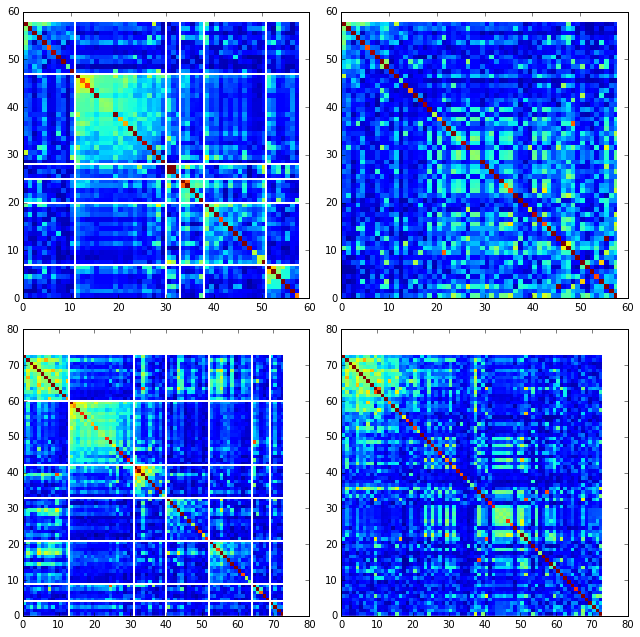

In [9]:
sectors = list()
ix = 1
for a in range(N_alg):
    #plot the SCA positional correlation matrix, ordered by contribution 
    #to the top ICs
    plt.rcParams['figure.figsize'] = 9, 9 
    plt.subplot(2,2,ix); ix +=1;
    plt.imshow(Dsca[a]['Csca'][np.ix_(Dsect[a]['sortedpos'],\
                Dsect[a]['sortedpos'])],vmin=0, vmax=2,\
               interpolation='none',aspect='equal',\
               extent=[0,sum(Dsect[a]['icsize']),0,\
                       sum(Dsect[a]['icsize'])])
    line_index=0
    for i in range(Dsect[a]['kpos']):
        plt.plot([line_index+Dsect[a]['icsize'][i],\
                  line_index+Dsect[a]['icsize'][i]],\
                 [0,sum(Dsect[a]['icsize'])],'w', linewidth = 2)
        plt.plot([0,sum(Dsect[a]['icsize'])],[sum(Dsect[a]['icsize'])\
                        -line_index,sum(Dsect[a]['icsize'])-line_index],\
                 'w', linewidth = 2)
        line_index += Dsect[a]['icsize'][i] 

    #combine all the ICs into a single sector and re-sort
    sec_groups = ([k for k in range(Dsect[a]['kpos'])])
    sectors_alg = list()
    s = sca.Unit()
    all_items = list()
    all_Vp = list()
    for i in range(Dsect[a]['kpos']): 
        all_items = all_items+Dsect[a]['ics'][i].items
        tmp1 = Dsect[a]['Vpica'][Dsect[a]['ics'][i].items,:]
        all_Vp = all_Vp + list(tmp1[:,0].T) 
    svals = list(np.argsort(all_Vp)); svals.reverse()  
    s.items = [all_items[i] for i in svals]
    s.col = (1/len(sec_groups))*n
    sectors_alg.append(s)
    sectors.append(sectors_alg)
    
    #plot the re-ordered matrix
    sortpos = list()
    for s in sectors[a]:
        sortpos.extend(s.items)
    plt.subplot(2,2,ix); ix += 1;
    line_index=0
    plt.imshow(Dsca[a]['Csca'][np.ix_(sortpos, sortpos)], \
               vmin=0, vmax=2,interpolation='none',aspect='equal',\
           extent=[0,len(sortpos),0,len(sortpos)])
    for s in sectors[a]:
        plt.plot([line_index+len(s.items),line_index+len(s.items)],\
                 [0,len(sortpos)],'w', linewidth = 2)
        plt.plot([0,sum(Dsect[a]['icsize'])],[len(sortpos)-line_index, \
                        len(sortpos)-line_index],'w', linewidth = 2)
        line_index += len(s.items)
    plt.tight_layout()

The below dendrogram diagrams the relationship between independent components for the PFAM alignment (the tree for the manual alignment is similar). In this plot, solid lines represent physically contiguous structural units, and dashed lines indicate spatially fragmented groups of residues. 

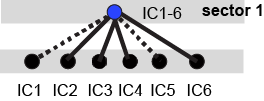

In [10]:
i = Image(filename='figs/DHFR_sec_hier.png'); i

Print the sector positions (as defined for each alignment), in a format suitable for pyMol, and create two pyMol sessions with the sectors (and decomposition into independent components) as seperate objects. 

In [11]:
for a in range(N_alg):
    print "Alignment: " + AlgName[a]
    for i,k in enumerate(sectors[a]):
        sort_ipos = sorted(k.items)
        ats_ipos = ([Dseq[a]['ats'][s] for s in sort_ipos])
        ic_pymol = ('+'.join(ats_ipos))
        print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
        print(ic_pymol + "\n")
        
sca.writePymol('1RX2', sectors[0], Dsect[0]['ics'], Dseq[0]['ats'],\
               'Outputs/PF00186.pml','A', '../Inputs/', 0)  
sca.writePymol('1RX2', sectors[1], Dsect[1]['ics'], Dseq[1]['ats'],\
               'Outputs/DHFR_PEPM3.pml','A', '../Inputs/', 0)  

Alignment: PFAM
Sector 1 is composed of 58 positions:
3+5+6+7+9+11+13+14+15+18+21+22+23+24+25+27+28+31+32+35+37+39+40+42+43+44+45+46+47+49+50+51+52+53+54+55+56+57+59+61+64+71+81+92+94+95+96+100+105+107+111+113+121+122+125+126+133+153

Alignment: Manual
Sector 1 is composed of 73 positions:
3+5+6+7+9+11+13+14+15+18+21+22+23+24+25+27+28+30+31+32+35+37+38+39+40+42+43+44+45+46+47+49+50+51+52+53+54+55+56+57+59+60+61+63+64+71+81+85+90+92+93+94+95+96+100+103+104+105+107+111+113+115+121+122+123+125+126+133+147+149+151+156+158



As is evident from the position lists above, and as shown below, the structural pattern of the two sectors and their associated decomposition into independent components is highly similar when compared between the two alignments. The main difference is that the sector (and independent components) for the manual alignment systematically includes a few more residue postions. 

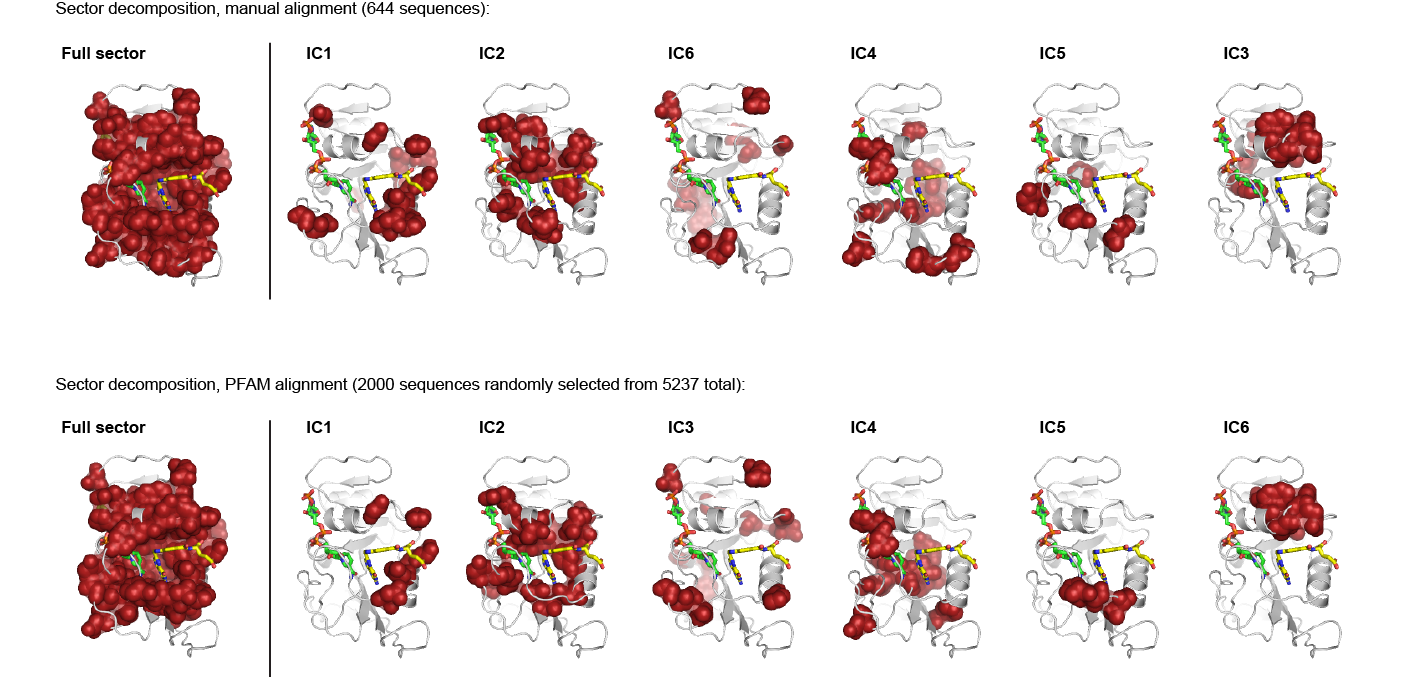

In [12]:
i = Image(filename='figs/DHFR_decompv2.png'); i

### III. The phylogenetic basis of the sector hierarchy

How does the clear phylogenetic heterogeneity in the MSA influence the sector definitions?  Since the sector definitions for the two alignments above are roughly equivalent, we only consider the larger (PFAM) alignment here. To address this, we take advantage of mathematical methods for mapping between the space of positional and sequence correlations, as described in *Rivoire et al*.  Using this mapping, we plot the top $k_{pos}$ ICs as 2-D scatter plots with the corresponding sequence space divergence.  

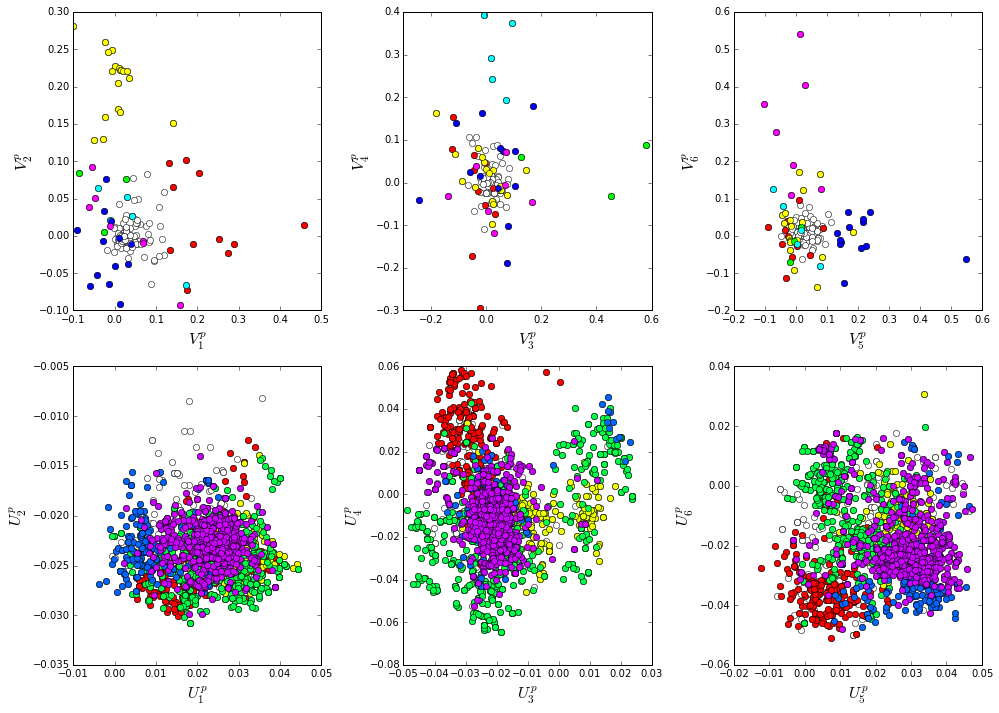

In [13]:
plt.rcParams['figure.figsize'] = 14, 10 
pairs= [[0,1],[2,3],[4,5]]
for n,[k1,k2] in enumerate(pairs):
    plt.subplot(2,3,n+1)
    sca.figUnits(Dsect[0]['Vpica'][:,k1], Dsect[0]['Vpica'][:,k2],\
                 Dsect[0]['ics'], dotsize = 6)
    plt.xlabel(r'$V^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$V^p_{%i}$' % (k2+1), fontsize=16)
    plt.subplot(2,3,n+4)
    sca.figUnits(Dsect[0]['Upica'][:,k1], Dsect[0]['Upica'][:,k2],\
                 phylo[0], dotsize = 6)
    plt.xlabel(r'$U^p_{%i}$' % (k1+1), fontsize=16)
    plt.ylabel(r'$U^p_{%i}$' % (k2+1), fontsize=16)
plt.tight_layout()

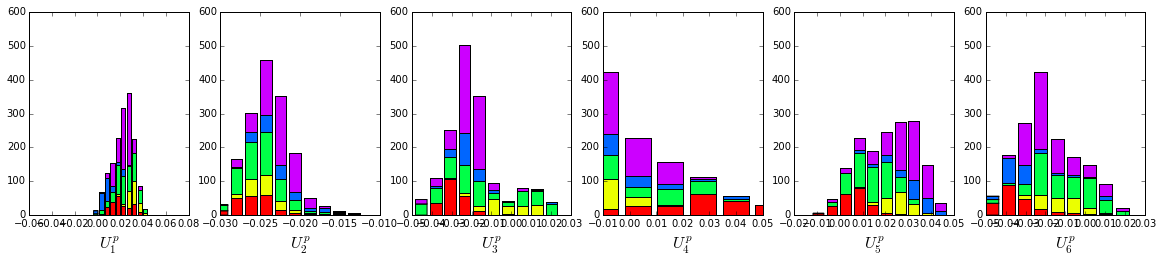

In [14]:
plt.rcParams['figure.figsize'] = 20,8 
col = list()
axis_lims = ([-0.06, 0.08],[-0.03, -0.01],[-0.05,0.03],[-0.01 ,0.05],\
             [-0.02 ,0.05],[-0.05 ,0.03])
for k in phylo[0]:
    col = col + [colorsys.hsv_to_rgb(k.col,1,1)]
for k in range(Dsect[0]['kpos']):
    forhist = list()
    for group in phylo[0]:
        forhist.append([Dsect[0]['Upica'][i,k] for i in group.items])
    plt.subplot(2,Dsect[0]['kpos'],k+1)
    plt.hist(forhist, histtype='barstacked',color=col)
    plt.axis([axis_lims[k][0],axis_lims[k][1],0,600])
    plt.xlabel(r'$U^p_{%i}$' % (k+1), fontsize=16) 

We see some association of phylogeny with sector positions at the phylum level: for example the positions along $V_3^p$ are associated with the divergence of some bacteriodetes *(yellow)* and firmicutes*(green)* along $U_3^p$.  Further, the  positions along ICs $V_1^p$,$V_5^p$ and $V_6^p$ seem to seperate the eukaryotes *(red)* from the prokaryotes.

So in conclusion, the DHFR family appears to have a single sector that can be decomposed into roughly six groups due to sequence divergence. Notably, the sector definition (and decomposition into ICs) is very similar for the two different sequence alignments. 